# Training 
 --------------------------------------------------------------------

Train a model using a snapshot of the data.

![Model deployment with streaming Real-time operational Pipeline](../../assets/images/model-deployment-with-streaming.png)

## Step 1: Load MLRun Project <a id="gs-step-project-create-n-config"></a>

Load the project

In [1]:
from mlrun import load_project, run_local, NewTask, import_function, mount_v3io
from os import path

project_path = path.abspath('conf')
project = load_project(project_path)
project_name = project.name

# Target location for storing pipeline artifacts
artifact_path = project.artifact_path
print(f'Artifacts path: {artifact_path}')

### Import and Configure Nuclio

[Nuclio](https://nuclio.io/) is a high-performance open-source and managed serverless framework, which is available as a predefined tenant-wide platform service (`nuclio`).
The tutorial uses Nuclio to create and deploy serverless functions.
Therefore, you need to import the Nuclio package and configure Nuclio for your project.

The platform's Jupyter Notebook service preinstalls the [nuclio-jupyter SDK](https://github.com/nuclio/nuclio-jupyter/blob/master/README.md) for creating and deploying Nuclio functions with Python and Jupyter Notebook.
The tutorial uses the Nuclio magic commands and annotation comments of this SDK to automate function code generation.
The magic commands are initialized when you import the `nuclio` package.<br>
The `%nuclio` magic commands are used to run Nuclio commands from Jupyter notebooks (`%nuclio <Nuclio command>`).
You can also use `%%nuclio` at the start of a cell to identify the entire cell as containing Nuclio code.
The magic commands are initialized when you import the `nuclio` package.<br>
The `# nuclio: start-code`, `# nuclio: end-code`, and `# nuclio: ignore` section-marker annotations notify Nuclio of the beginning or end of code sections.
Nuclio ignores all notebook code before a `# nuclio: start-code` marker or after an `# nuclio: end-code` marker.
Nuclio translates all other notebook code sections into function code, except for sections that are marked with the `# nuclio: ignore` marker.

#### Import Nuclio

The following code imports the `nuclio` Python package.

In [3]:
import nuclio

#### Configure Nuclio

The following code uses the `# nuclio: start-code` marker to instruct Nuclio to start processing code only from this location, and then performs basic Nuclio function configuration &mdash; defining the name of the function's container image (`mlrun/ml-models`) and the function type (`job`).

> **Note:** You can add code to define function dependencies and perform additional configuration after the `# nuclio: start-code` marker.

In [4]:
# nuclio: start-code

In [5]:
%nuclio config spec.build.baseImage = "mlrun/ml-models"
%nuclio config kind = "job"
%nuclio cmd -c pip install v3io-frames==0.6.18

%nuclio: setting spec.build.baseImage to 'mlrun/ml-models'
%nuclio: setting kind to 'job'


## Step 2: Take a Snapshot Data Set of the KV feature table <a id="gs-step-ingest-data"></a>


### Initialization <a id="gs-step-ingest-data-init"></a>


In [6]:
# nuclio: ignore
# Set the source-data URL
container = project.params.get('CONTAINER')
table_path = '/' + project.params.get('FEATURE_TABLE_PATH')
columns = ['label', 'socioeconomic_idx', 
           'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 
           'bet_sum', 'bet_mean', 'bet_count' ,'bet_var',
           'win_sum', 'win_mean', 'win_count' ,'win_var']
format = 'csv'

### Define a Data-Snapshot Function <a id="gs-step-ingest-data-define-function"></a>


In [7]:
from os import path
import pandas as pd
import v3io_frames as v3f


# Ingest a data set into the platform
def snapshot_data(context, container, table_path, columns, format='csv'):
    
    client = v3f.Client("framesd:8081", container=container)
    client.execute(backend="kv", table=table_path, command="infer")
    df = client.read('kv', table_path, columns=columns)
    
    target_path = path.join(context.artifact_path, 'data')
    # Optionally print data to your logger
    context.logger.info('Saving snapshot data set to {} ...'.format(target_path))
    
    # Store the data set in your artifacts database
    context.log_dataset('snapshot_dataset', df=df, format=format,
                        index=False, artifact_path=target_path)

The following cell uses the `# nuclio: end-code` marker to mark the end of a Nuclio code section and instruct Nuclio to stop parsing the notebook at this point.<br>
> **IMPORTANT:** Do not remove the end-code cell.

In [8]:
# nuclio: end-code

<a id='gs-run-ingest-func-local'></a>
#### Run the Function Locally in Jupyter Notebook

In [9]:
# Run the data-ingestion function locally in Jupyter Notebook
snapshot_data_run = run_local(name='snapshot_data',
                         handler=snapshot_data,
                         params={'container': container, 'table_path': table_path, 
                                 'columns':columns, 'format': format},
                         project=project_name, artifact_path=artifact_path)

> 2020-08-20 11:35:37,679 [info] starting run snapshot_data uid=61807f36ae35416ebffe74a5e8d7a72f  -> http://mlrun-api:8080
> 2020-08-20 11:35:38,095 [info] Saving snapshot data set to /User/work/tutorials/demos/model-deployment-with-streaming/artifacts/data ...


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-deployment-with-streaming-iguazio,...e8d7a72f,0,Aug 20 11:35:37,completed,snapshot_data,v3io_user=iguaziokind=handlerowner=iguaziohost=jupyter-698f4b5d7f-gmdxt,,"container=userstable_path=/iguazio/examples/model-deployment-with-streaming/data/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 61807f36ae35416ebffe74a5e8d7a72f --project model-deployment-with-streaming-iguazio , !mlrun logs 61807f36ae35416ebffe74a5e8d7a72f --project model-deployment-with-streaming-iguazio
> 2020-08-20 11:35:38,455 [info] run executed, status=completed


#### Run the Function on a Cluster <a id="gs-run-ingest-func-cluster"></a>


In [10]:
from mlrun import code_to_function

# Convert the local snapshot_data function into a gen_func project function
gen_func = code_to_function(name='snapshot-data')
project.set_function(gen_func)
snapshot_data_func = project.func('snapshot-data').apply(mount_v3io())

In [11]:
#Build image
snapshot_data_func.deploy()

> 2020-08-20 11:35:48,167 [info] starting remote build, image: .mlrun/func-model-deployment-with-streaming-iguazio-snapshot-data-latest
INFO[0000] Resolved base name mlrun/ml-models:0.5.1 to mlrun/ml-models:0.5.1 
INFO[0000] Resolved base name mlrun/ml-models:0.5.1 to mlrun/ml-models:0.5.1 
INFO[0000] Retrieving image manifest mlrun/ml-models:0.5.1 
INFO[0000] Retrieving image manifest mlrun/ml-models:0.5.1 
INFO[0002] Built cross stage deps: map[]                
INFO[0002] Retrieving image manifest mlrun/ml-models:0.5.1 
INFO[0002] Retrieving image manifest mlrun/ml-models:0.5.1 
INFO[0002] Unpacking rootfs as cmd RUN pip install v3io-frames==0.6.18 requires it. 
INFO[0144] Taking snapshot of full filesystem...        
INFO[0155] Resolving paths                              
INFO[0200] RUN pip install v3io-frames==0.6.18          
INFO[0200] cmd: /bin/sh                                 
INFO[0200] args: [-c pip install v3io-frames==0.6.18]   
  Attempting uninstall: grpcio
    Found 

True

##### Run the Function on the Cluster <a id="gs-run-ingest-func-on-the-cluster-run-function"></a>


In [12]:
snapshot_data_run = snapshot_data_func.run(name='snapshot_data',
                                 handler='snapshot_data',
                                 params={'container': container, 'table_path': table_path, 
                                         'columns':columns, 'format': format},
                                 artifact_path=artifact_path)

> 2020-08-20 11:40:32,304 [info] starting run snapshot_data uid=96e80a8867914f6c8f213a3926581e57  -> http://mlrun-api:8080
> 2020-08-20 11:40:32,518 [info] Job is running in the background, pod: snapshot-data-c4dts
> 2020-08-20 11:40:41,081 [info] Saving snapshot data set to /User/work/tutorials/demos/model-deployment-with-streaming/artifacts/data ...
> 2020-08-20 11:40:41,296 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-deployment-with-streaming-iguazio,...26581e57,0,Aug 20 11:40:40,completed,snapshot_data,v3io_user=iguaziokind=jobowner=iguaziohost=snapshot-data-c4dts,,"container=userstable_path=/iguazio/examples/model-deployment-with-streaming/data/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 96e80a8867914f6c8f213a3926581e57 --project model-deployment-with-streaming-iguazio , !mlrun logs 96e80a8867914f6c8f213a3926581e57 --project model-deployment-with-streaming-iguazio
> 2020-08-20 11:40:44,770 [info] run executed, status=completed


## Step 3: Explore the Data <a id="gs-step-explore-data"></a>


### Explore the Data with Pandas DataFrames <a id="gs-explore-data-w-pandas-df"></a>


Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [13]:
# Read your data set
from mlrun.run import get_dataitem
df = get_dataitem(snapshot_data_run.outputs['snapshot_dataset']).as_df()

In [14]:
# Display a portion of the read data
df.head()

,label,socioeconomic_idx,purchase_sum,purchase_mean,purchase_count,purchase_var,bet_sum,bet_mean,bet_count,bet_var,win_sum,win_mean,win_count,win_var
0,0,5,1210.0,53.0,22.0,150.0,2021.0,11.0,208.0,6.0,2342.0,235.0,10.0,750.0
1,1,3,4400.0,44.0,93.0,140.0,7962.0,10.0,832.0,5.0,1798.0,181.0,10.0,2362.0
2,1,1,4553.0,49.0,94.0,147.0,7142.0,11.0,743.0,7.0,620.0,207.0,3.0,3637.0
3,1,3,3791.0,46.0,79.0,120.0,7988.0,10.0,833.0,5.0,1518.0,190.0,8.0,1640.0
4,1,5,4779.0,48.0,98.0,133.0,7310.0,10.0,770.0,5.0,1018.0,204.0,5.0,1979.0


In [15]:
# Calculate and display the number of data-set items
print(f'Total number of rows: {len(df)}')

Total number of rows: 1890


In [16]:
# Display statistics grouped by label
df.groupby(['label']).describe()

socioeconomic_idx                                               \
                  count      mean       std  min  25%  50%  75%  max   
label                                                                  
0                 559.0  5.087657  1.267674  3.0  4.0  5.0  6.0  7.0   
1                1331.0  2.970699  1.309266  1.0  2.0  3.0  4.0  5.0   

      purchase_sum               ... win_count       win_var               \
             count         mean  ...       75%   max   count         mean   
label                            ...                                        
0            548.0  1139.846715  ...      15.0  53.0   517.0  2093.108317   
1           1323.0  4154.821618  ...      11.0  21.0  1291.0  2176.972889   

                                                          
               std  min     25%     50%     75%      max  
label                                                     
0      1203.416905  0.0  1454.0  2105.0  2644.0  10952.0  
1      1059.263482  0.0  1559.5  2154.0  2744.0  12482.0  

[2 rows x 104 columns]

### Explore the Data with an MLRun Marketplace Function <a id="gs-explore-data-w-mlrun-func"></a>


#### Add an Exploration Function <a id="gs-explore-data-w-mlrun-func-add-func"></a>


In [17]:
project.set_function('hub://describe', 'describe')
describe = project.func('describe').apply(mount_v3io())

#### Run the Exploration Function <a id="gs-explore-data-w-mlrun-func-run-func"></a>


In [18]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    snapshot_data_run.outputs['snapshot_dataset']},
                            artifact_path=artifact_path)

> 2020-08-20 11:40:45,200 [info] starting run describe-summarize uid=91654dab484b4645bd4fd05c705cb06e  -> http://mlrun-api:8080
> 2020-08-20 11:40:45,499 [info] Job is running in the background, pod: describe-summarize-9c4qr
> 2020-08-20 11:41:39,874 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-deployment-with-streaming-iguazio,...705cb06e,0,Aug 20 11:40:52,completed,describe-summarize,v3io_user=iguaziokind=jobowner=iguaziohost=describe-summarize-9c4qr,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 91654dab484b4645bd4fd05c705cb06e --project model-deployment-with-streaming-iguazio , !mlrun logs 91654dab484b4645bd4fd05c705cb06e --project model-deployment-with-streaming-iguazio
> 2020-08-20 11:41:44,963 [info] run executed, status=completed


#### Review the Run Output <a id="gs-explore-data-w-mlrun-func-run-output-review"></a>



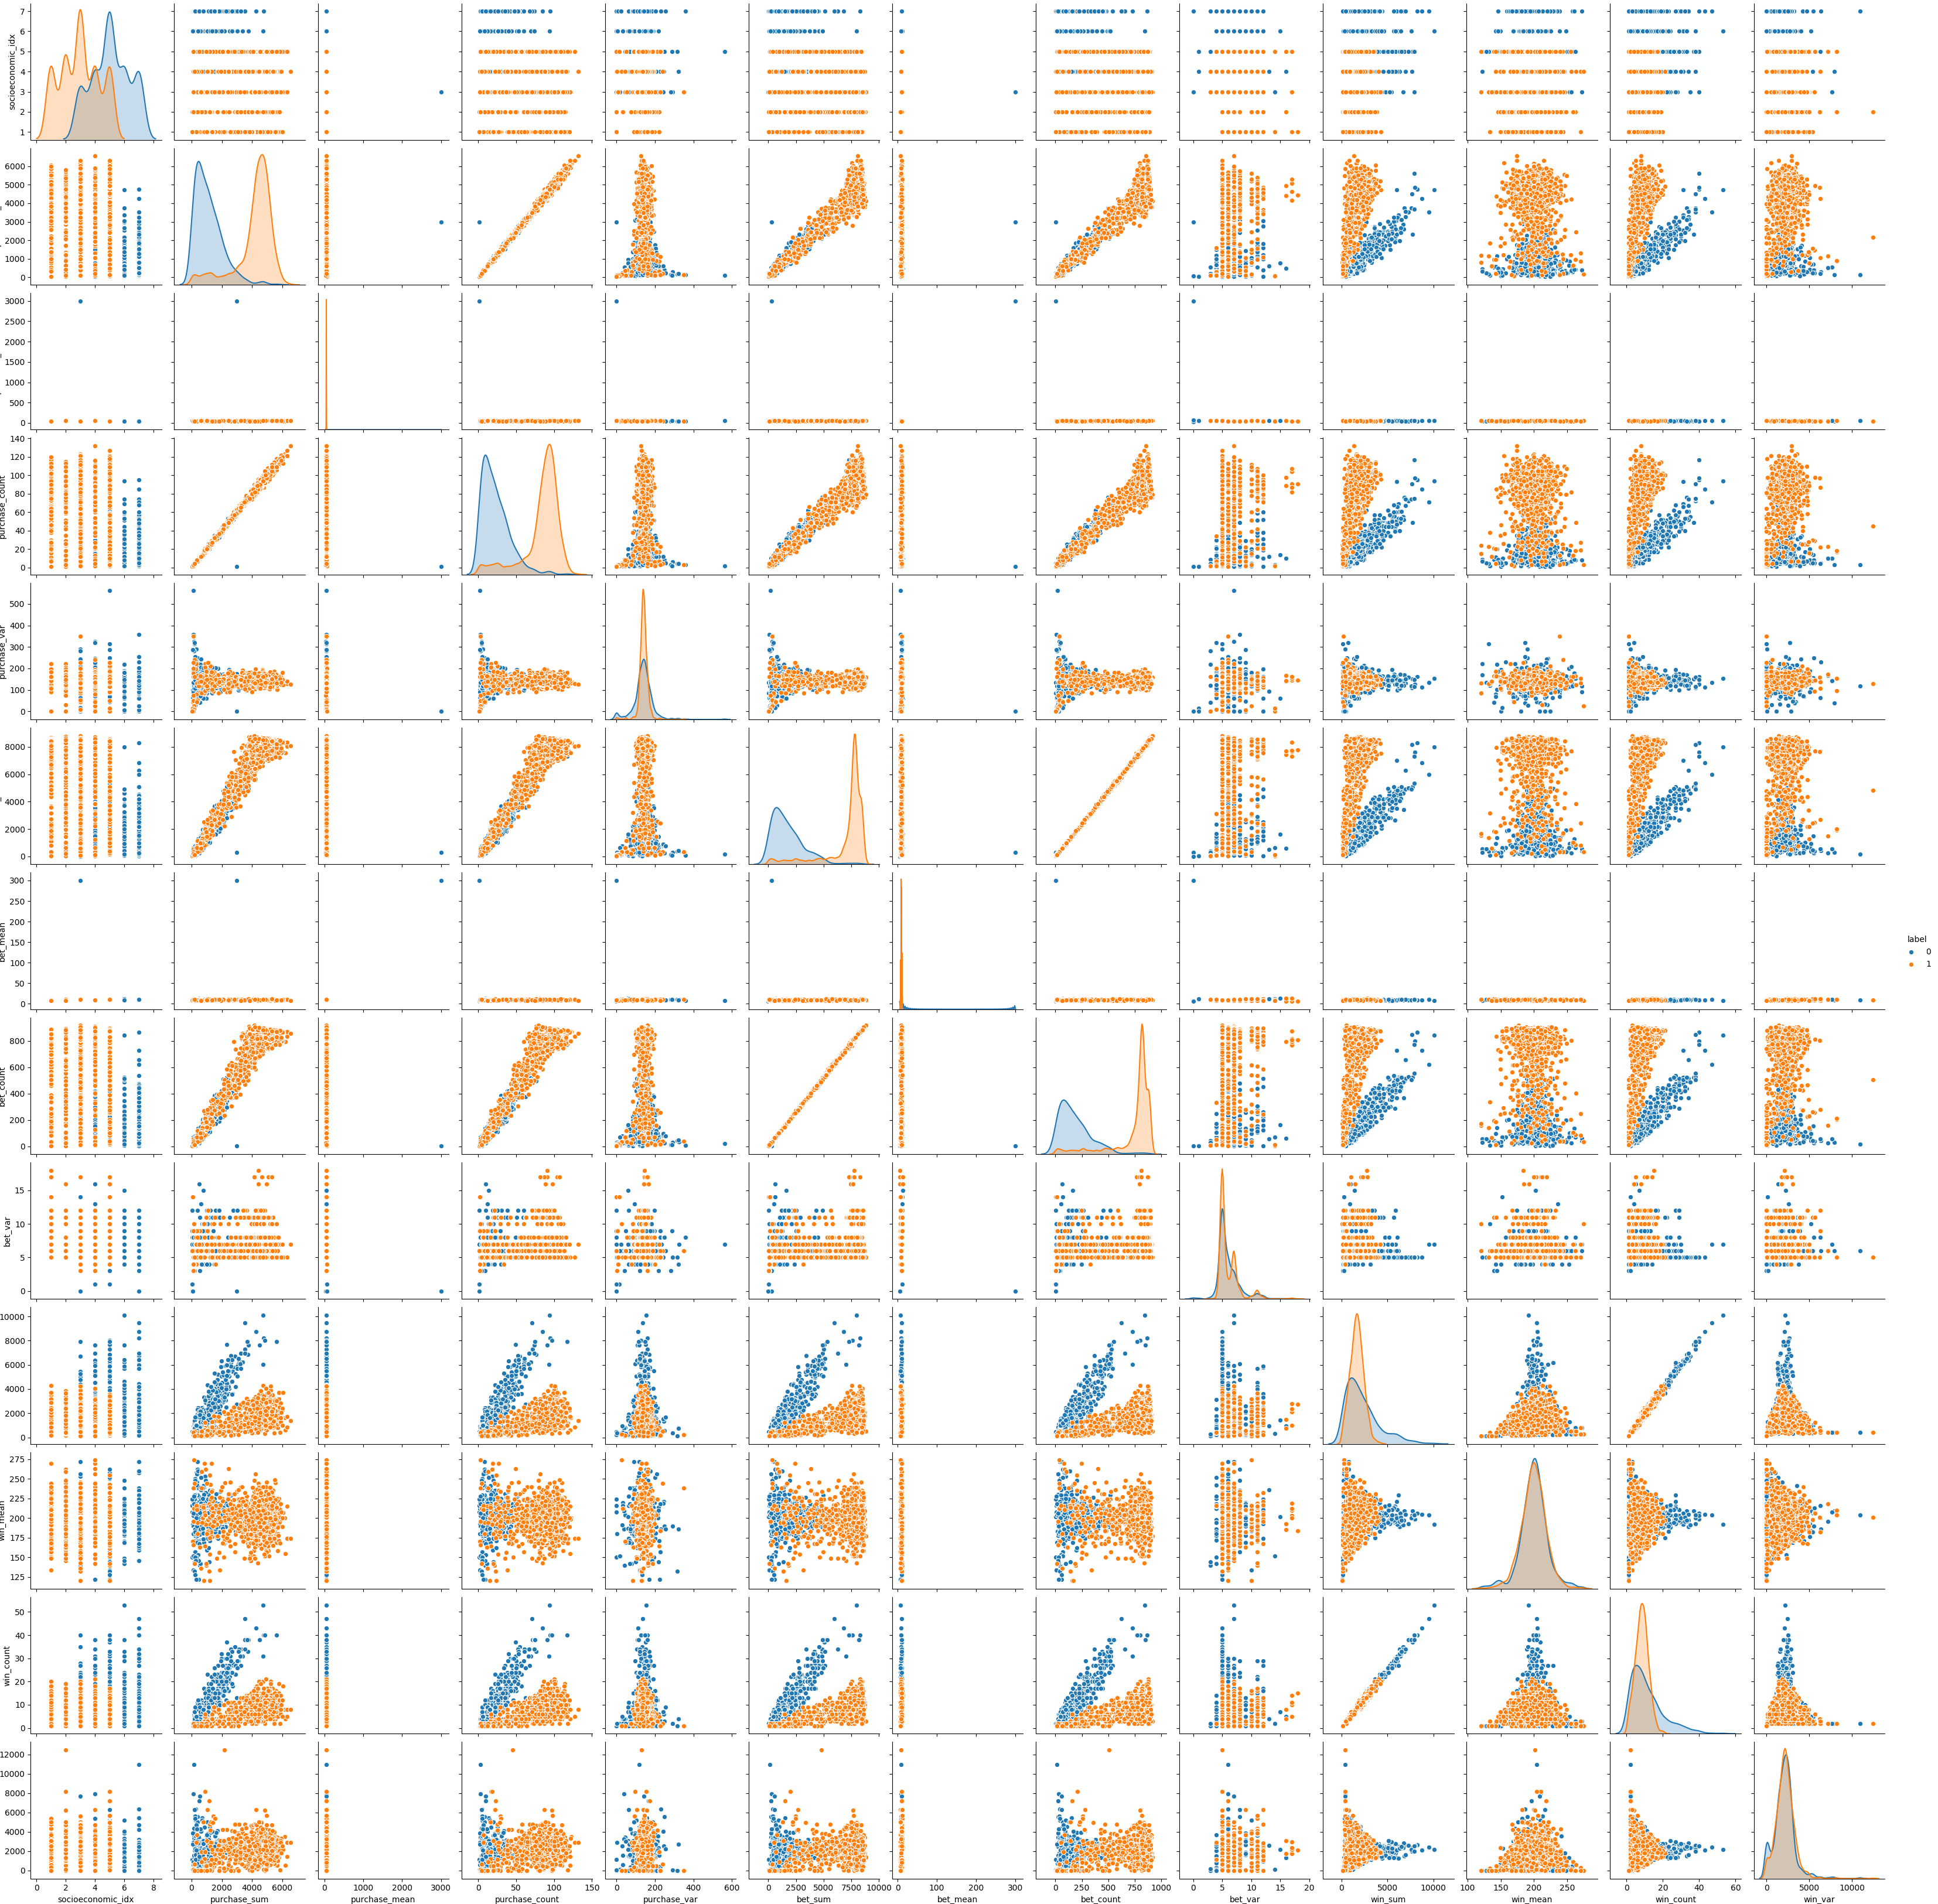

In [19]:
from IPython.display import display, HTML

# Display the `histograms` artifact
display(HTML('<h3>Histograms</h3>'), HTML(describe_run.outputs['histograms']))


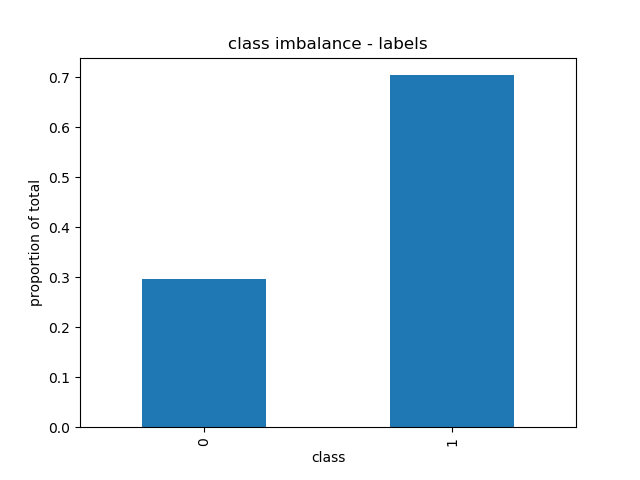

In [20]:
# Display the `imbalance` artifact
display(HTML('<h3>Imbalance<h3>'),
        HTML(filename=describe_run.outputs['imbalance']))


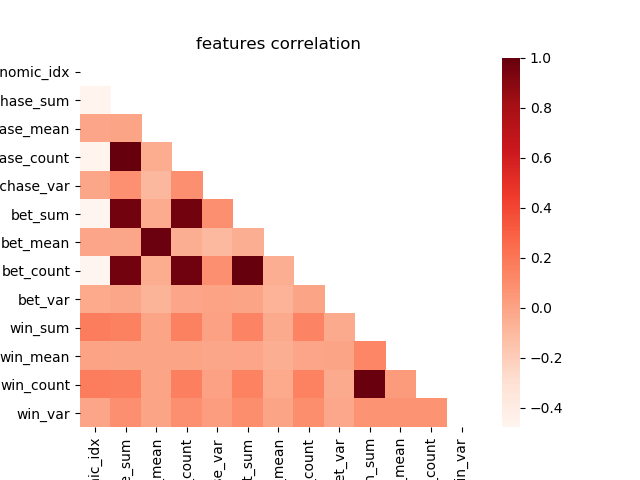

In [21]:
# Display the `correlation` artifact
display(HTML('<h3>Correlation Matrix<h3>'),
        HTML(filename=describe_run.outputs['correlation']))

## Step 4: Run Model Training at Scale <a id="gs-step-run-model-training"></a>


#### Add a Training Function <a id="gs-train-model-add-func"></a>


In [22]:
project.set_function('hub://sklearn_classifier', 'train')
train = project.func('train').apply(mount_v3io())

#### Run a Model-Training Task <a id="gs-train-model-run-task"></a>

##### Few useful parameters:
:param label_column:      ground-truth (y) labels.</br>
:param encode_cols:       dictionary of names and prefixes for columns that are
                          to hot be encoded.</br>
:param sample:            Selects the first n rows, or select a sample
                          starting from the first. If negative <-1, select
                          a random sample, -1 selects all rows.</br>
:param test_size:         (0.05) test set size.</br>
:param train_val_split:   (0.75) Once the test set has been removed the
                          training set gets this proportion.</br>
:param model_evaluator:   (None) a custom model evaluator can be specified.</br>
:param models_dest:       model's subfolder on artifact path, 
                          in our example, running different models as hyper parameters, 
                          it will be <artifact_path>/model<i>/model.pkl.</br>
:param plots_dest:        plot subfolder on artifact path.</br>

    
function's source and full docstrings can be afound at https://github.com/mlrun/functions/tree/master/sklearn_classifier

In [23]:
# Configure the models to train
models = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

In [24]:
# Create a training task
train_task = NewTask(name="train",
                     params={"sample": -1,
                             "label_column": "label",
                             "test_size": 0.10},
                     inputs={"dataset": snapshot_data_run.outputs['snapshot_dataset']})

# Run the training task
train_run = train.run(train_task.with_hyper_params({'model_pkg_class': models},
                                                   selector='max.accuracy'),
                      artifact_path=artifact_path)

> 2020-08-20 11:41:45,335 [info] starting run train uid=ff686d6e785f422f8ad4471237c36b3c  -> http://mlrun-api:8080
> 2020-08-20 11:41:45,607 [info] Job is running in the background, pod: train-sfwtf
> 2020-08-20 11:41:56,077 [info] best iteration=1, used criteria max.accuracy
> 2020-08-20 11:41:56,666 [info] run executed, status=completed
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...37c36b3c,0,Aug 20 11:41:50,completed,train,v3io_user=iguaziokind=jobowner=iguazio,dataset,sample=-1label_column=labeltest_size=0.1,best_iteration=1accuracy=0.9852579852579852test-error=0.014742014742014743rocauc=0.999580863421352brier_score=0.010035872235872236f1-score=0.9897260273972602precision_score=0.993127147766323recall_score=0.9863481228668942,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run ff686d6e785f422f8ad4471237c36b3c --project default , !mlrun logs ff686d6e785f422f8ad4471237c36b3c --project default
> 2020-08-20 11:42:04,853 [info] run executed, status=completed


### Review the Run Output <a id="gs-train-model-run-output-review"></a>



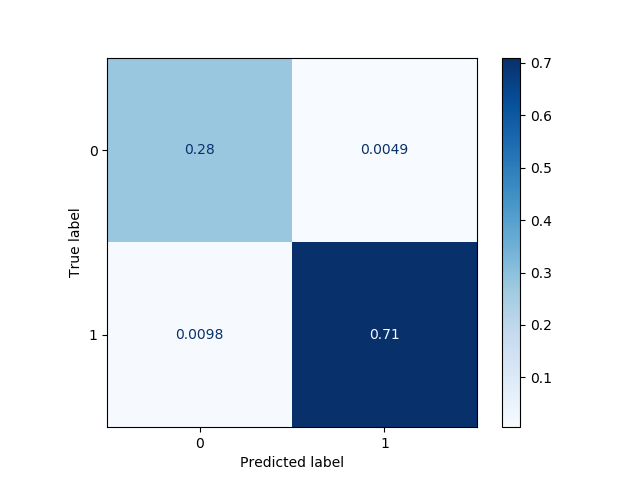


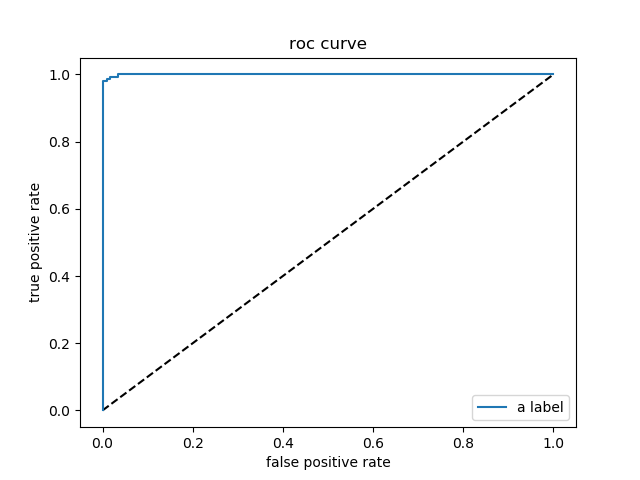

In [25]:
# Display the name of the selected model
display(HTML(f'<b>Best model:</b> '
             f'{models[train_run.outputs["best_iteration"]-1]}'))

# Display the accuracy for the optimal run iteration
display(HTML(f'<b>Accuracy:</b> {train_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML('<h3>Confusion Matrix:</h3>'),
        HTML(filename=train_run.outputs['confusion-matrix']))
display(HTML('<h3>ROC Curve:</h3>'), HTML(filename=train_run.outputs['roc-binary']))

## Step 5: Test Your Model <a id="gs-step-test-model"></a>


In [26]:
project.set_function('hub://test_classifier', 'test')
test = project.func('test').apply(mount_v3io())

#### Run a Model-Testing Task <a id="gs-test-model-run-task"></a>


In [27]:
test_task = NewTask(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']}
                    )
test_run = test.run(test_task,
                    artifact_path=artifact_path)

> 2020-08-20 11:45:27,095 [info] starting run test uid=9917466c03b34df0b1f9e147f568a682  -> http://mlrun-api:8080
> 2020-08-20 11:45:27,279 [info] Job is running in the background, pod: test-8n25c
> 2020-08-20 11:45:34,169 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...f568a682,0,Aug 20 11:45:32,completed,test,v3io_user=iguaziokind=jobowner=iguaziohost=test-8n25c,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=0.9834254143646409test-error=0.016574585635359115rocauc=0.9989285714285714brier_score=0.013347513812154698f1-score=0.9878542510121457precision_score=1.0recall_score=0.976,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarytest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 9917466c03b34df0b1f9e147f568a682 --project default , !mlrun logs 9917466c03b34df0b1f9e147f568a682 --project default
> 2020-08-20 11:45:36,464 [info] run executed, status=completed


### Review the Run Output <a id="gs-test-model-run-output-review"></a>



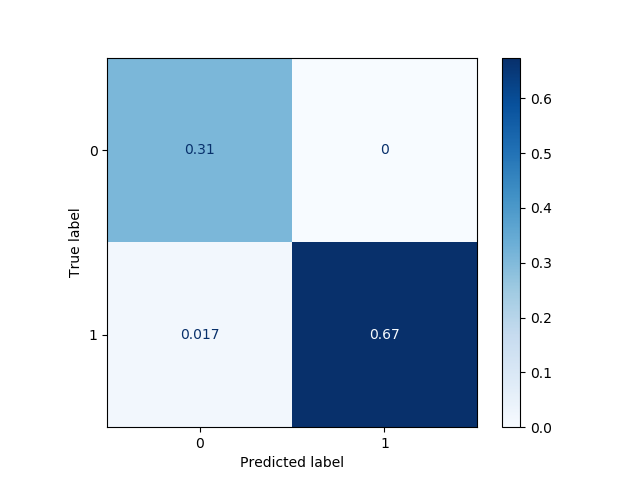


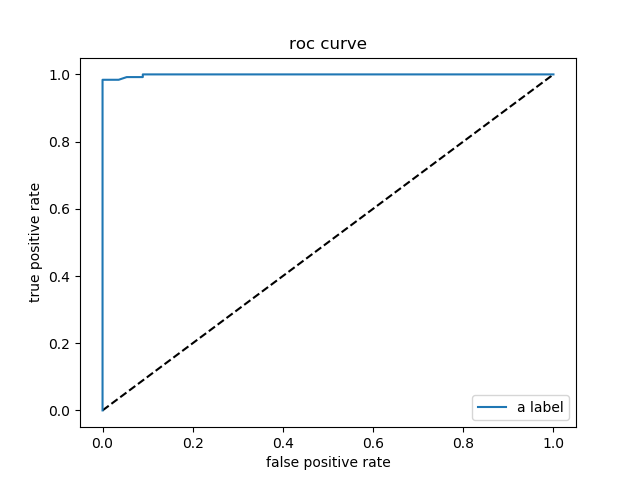

In [28]:
# Display the model accuracy
display(HTML(f'<b>Test Accuracy:</b> {test_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML("<h3>Confusion matrix:</h3>"),
        HTML(filename=test_run.outputs['confusion-matrix']))
display(HTML("<h3>ROC Curve:</h3>"), HTML(filename=test_run.outputs['roc-binary']))

## Step 6: Save project<a id="gs-step-create-n-run-ml-pipeline"></a>


In [29]:
project.save()